# Degree Correlations Analysis: Real-world vs. Random Networks

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import urllib.request
from tqdm.notebook import tqdm

# Setting the random seed for reproducibility
np.random.seed(42)

## 1. Load the Real-world Network

In [2]:
def load_arxiv_network():
    """
    Load the arXiv HEP-TH citation network.
    Returns a directed graph.
    """
    # File name
    edges_file = "cit-HepTh.txt\Cit-HepTh.txt"
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from the citation file
    with open(edges_file, 'r') as f:
        for line in f:
            # Skip comment lines starting with #
            if line.startswith('#'):
                continue
            # Parse the line
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = parts
                G.add_edge(source, target)
    
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

# Load the network
G_original = load_arxiv_network()

# Since degree correlations may be more meaningful in undirected networks,
# let's convert the directed network to undirected
G = G_original.to_undirected()
print(f"Converted to undirected graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded graph with 27770 nodes and 352807 edges
Converted to undirected graph with 27770 nodes and 352324 edges


## 2. Computing Degree Correlations (knn vs k)

In [3]:
def compute_knn(G):
    """
    Compute the average degree of neighbors for each degree k.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph to analyze
    
    Returns:
    --------
    tuple
        Dictionary mapping degree k to average neighbor degree knn,
        and dictionary mapping degree k to number of nodes with that degree
    """
    # Get the average neighbor degree for each node
    avg_nbr_deg = nx.average_neighbor_degree(G)
    
    # Group by node degree
    knn_by_k = defaultdict(list)
    for node, k_avg in avg_nbr_deg.items():
        degree = G.degree(node)
        knn_by_k[degree].append(k_avg)
    
    # Compute average knn for each degree k
    knn_avg = {}
    counts = {}
    for k, knn_list in knn_by_k.items():
        knn_avg[k] = np.mean(knn_list)
        counts[k] = len(knn_list)
    
    return knn_avg, counts

# Compute knn for the real-world network
real_knn, real_counts = compute_knn(G)

print("Computed knn vs k for the real-world network")
print(f"Found {len(real_knn)} distinct degree values")

Computed knn vs k for the real-world network
Found 324 distinct degree values



## 3. Generating Random Networks with Configuration Model


In [4]:
def configuration_model(G_original, num_instances=100):
    """
    Generate multiple random graphs using the configuration model that preserve
    the degree sequence of the original undirected graph.
    
    Parameters:
    -----------
    G_original : networkx.Graph
        The original undirected graph
    num_instances : int
        Number of random graph instances to generate
    
    Returns:
    --------
    list of networkx.Graph
        A list of random graphs with the same degree sequence
    """
    random_graphs = []
    
    # Extract the degree sequence from the original graph
    degree_sequence = [d for _, d in G_original.degree()]
    
    print(f"Generating {num_instances} random graphs using Configuration Model...")
    for i in tqdm(range(num_instances), desc="Generating random graphs"):
        # Create a new random graph with the same degree sequence
        G_random = nx.configuration_model(degree_sequence, seed=i)
        
        # Convert to a simple graph (remove self-loops and parallel edges)
        G_random = nx.Graph(G_random)
        
        random_graphs.append(G_random)
    
    return random_graphs

# Generate random graphs
random_graphs = configuration_model(G, num_instances=100)
print(f"Successfully generated {len(random_graphs)} random graphs")

Generating 100 random graphs using Configuration Model...


Generating random graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully generated 100 random graphs


## 4. Computing Average knn for Random Graphs

In [5]:
def compute_average_knn(graph_list):
    """
    Compute the average knn across multiple random graphs.
    
    Parameters:
    -----------
    graph_list : list of networkx.Graph
        List of random graph instances
    
    Returns:
    --------
    tuple
        Dictionary mapping degree k to average knn across all graphs,
        Dictionary mapping degree k to number of nodes with that degree
    """
    # Store sum of knn values for each degree
    knn_sum = defaultdict(float)
    count_sum = defaultdict(int)
    
    # Process each graph
    print("Computing knn for each random graph...")
    for i, G in enumerate(tqdm(graph_list, desc="Processing random graphs")):
        # Compute knn for this graph
        knn, counts = compute_knn(G)
        
        # Update the sums
        for k, avg_knn in knn.items():
            knn_sum[k] += avg_knn * counts[k]  # Weighted by number of nodes
            count_sum[k] += counts[k]
    
    # Compute the weighted average
    knn_avg = {}
    for k in knn_sum:
        if count_sum[k] > 0:
            knn_avg[k] = knn_sum[k] / count_sum[k]
    
    return knn_avg, count_sum

# Compute average knn for random graphs
random_knn, random_counts = compute_average_knn(random_graphs)
print(f"Computed average knn vs k for {len(random_graphs)} random graphs")
print(f"Found {len(random_knn)} distinct degree values")

Computing knn for each random graph...


Processing random graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Computed average knn vs k for 100 random graphs
Found 955 distinct degree values


## 5. Visualizing and Comparing Results

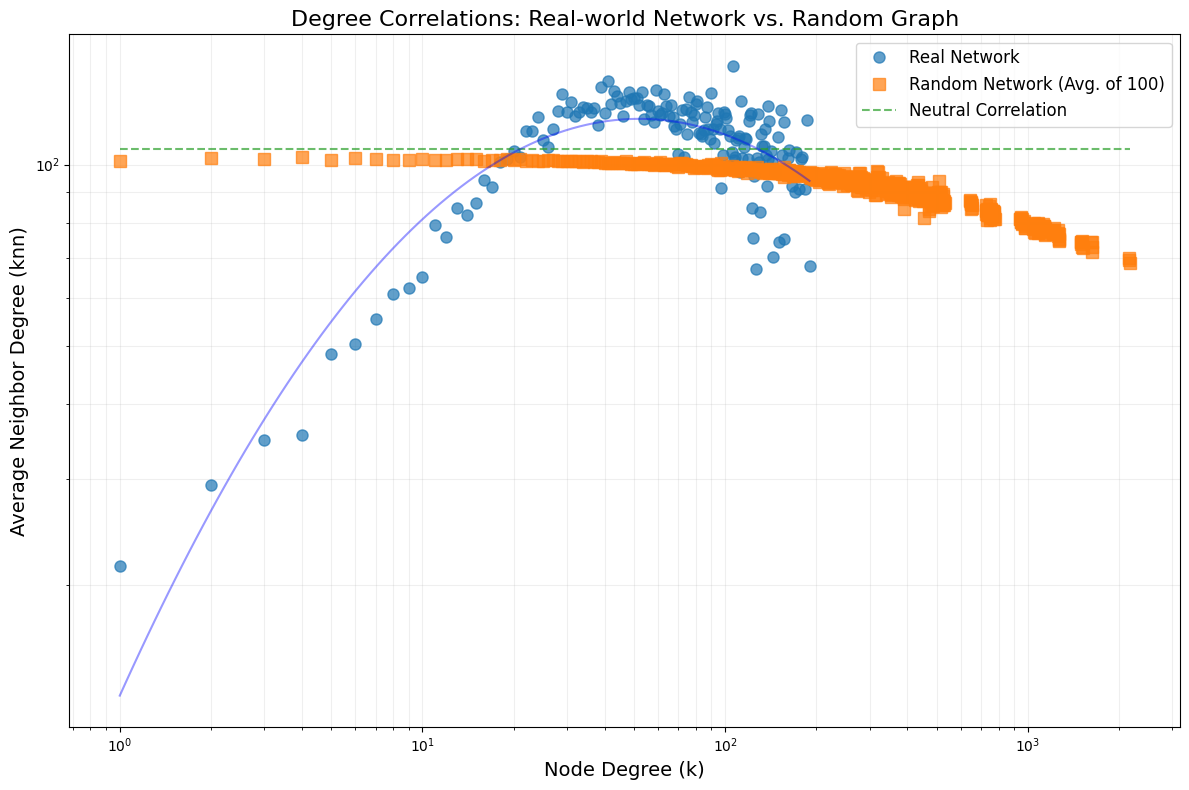

Plot saved as knn_comparison.png


In [6]:
def plot_knn_comparison(real_knn, real_counts, random_knn, random_counts, filename='knn_comparison.png'):
    """
    Create a comparison plot of knn vs k for real and random networks.
    
    Parameters:
    -----------
    real_knn : dict
        Dictionary mapping degree k to knn for the real network
    real_counts : dict
        Dictionary mapping degree k to number of nodes with that degree in real network
    random_knn : dict
        Dictionary mapping degree k to average knn for random networks
    random_counts : dict
        Dictionary mapping degree k to average number of nodes with that degree in random networks
    filename : str
        Name of the file to save the plot
    """
    plt.figure(figsize=(12, 8))
    
    # Filter out degrees with very few nodes for clarity
    min_count = 5
    real_filtered = {k: v for k, v in real_knn.items() if real_counts[k] >= min_count}
    random_filtered = {k: v for k, v in random_knn.items() if random_counts[k] >= min_count}
    
    # Plot real network data
    real_degrees = list(real_filtered.keys())
    real_knn_values = list(real_filtered.values())
    plt.loglog(real_degrees, real_knn_values, 'o', label='Real Network', markersize=8, alpha=0.7)
    
    # Plot random network data
    random_degrees = list(random_filtered.keys())
    random_knn_values = list(random_filtered.values())
    plt.loglog(random_degrees, random_knn_values, 's', label='Random Network (Avg. of 100)', markersize=8, alpha=0.7)
    
    # Add reference line for neutral correlation
    max_k = max(max(real_degrees), max(random_degrees))
    k_reference = np.logspace(0, np.log10(max_k), 100)
    
    # For neutral correlation, knn would be independent of k
    # In a configuration model with no degree correlations, knn ~ <k²>/<k>
    avg_k = sum(d * c for d, c in real_counts.items()) / sum(real_counts.values())
    avg_k_squared = sum(d * d * c for d, c in real_counts.items()) / sum(real_counts.values())
    neutral_knn = avg_k_squared / avg_k
    
    plt.loglog(k_reference, [neutral_knn] * len(k_reference), '--', label='Neutral Correlation', alpha=0.7)
    
    # Add curved line for visual guidance through real data points
    try:
        # Sort by x values for smooth curve
        sorted_indices = np.argsort(real_degrees)
        sorted_x = np.array(real_degrees)[sorted_indices]
        sorted_y = np.array(real_knn_values)[sorted_indices]
        
        # Use polynomial fit for trend line
        log_x = np.log10(sorted_x)
        log_y = np.log10(sorted_y)
        z = np.polyfit(log_x, log_y, 2)
        p = np.poly1d(z)
        
        # Create smooth curve
        smooth_x = np.logspace(np.log10(min(sorted_x)), np.log10(max(sorted_x)), 100)
        smooth_log_y = p(np.log10(smooth_x))
        smooth_y = 10 ** smooth_log_y
        
        plt.loglog(smooth_x, smooth_y, '-', color='blue', alpha=0.4)
    except:
        # Skip trend line if fitting fails
        pass
    
    # Labels and styling
    plt.xlabel('Node Degree (k)', fontsize=14)
    plt.ylabel('Average Neighbor Degree (knn)', fontsize=14)
    plt.title('Degree Correlations: Real-world Network vs. Random Graph', fontsize=16)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    return filename

# Create the comparison plot
plot_filename = plot_knn_comparison(real_knn, real_counts, random_knn, random_counts)
print(f"Plot saved as {plot_filename}")


## 6. Analyzing the Results


Degree Correlation Analysis:

1. Real-world Network:
    - The network shows assortative mixing, where nodes with high degree tend to connect to other high-degree nodes.
    - Average correlation trend: 0.5850

2. Random Network (Configuration Model):
    - The random network shows neutral mixing.
    - Average correlation trend: 0.0073

3. Comparison:
    - The real-world network's degree correlation is different from 
        what would be expected in a random network with the same degree sequence.
    - This suggests that there is a non-random structure in how nodes of different degrees connect to each other in the real network.

## 7. Computing Assortativity Coefficient

In [8]:
# Another way to quantify degree correlation is through the assortativity coefficient
real_assortativity = nx.degree_assortativity_coefficient(G)
random_assortativity = []

print("Computing assortativity coefficient for random graphs...")
for G_random in tqdm(random_graphs, desc="Processing random graphs"):
    random_assortativity.append(nx.degree_assortativity_coefficient(G_random))

avg_random_assortativity = np.mean(random_assortativity)
std_random_assortativity = np.std(random_assortativity)

print(f"\nAssortativity Coefficient:")
print(f"Real Network: {real_assortativity:.4f}")
print(f"Random Networks (avg ± std): {avg_random_assortativity:.4f} ± {std_random_assortativity:.4f}")

Computing assortativity coefficient for random graphs...


Processing random graphs:   0%|          | 0/100 [00:00<?, ?it/s]


Assortativity Coefficient:
Real Network: -0.0303
Random Networks (avg ± std): -0.0199 ± 0.0006


## 8. Additional Visualization: Assortativity Distribution

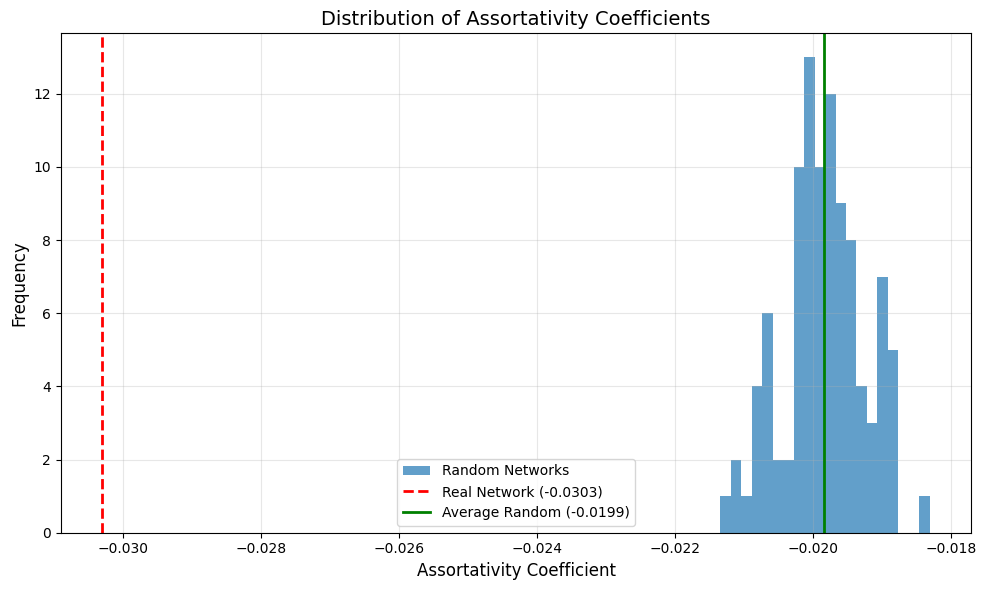

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(random_assortativity, bins=20, alpha=0.7, label='Random Networks')
plt.axvline(real_assortativity, color='red', linestyle='--', linewidth=2, 
            label=f'Real Network ({real_assortativity:.4f})')
plt.axvline(avg_random_assortativity, color='green', linestyle='-', linewidth=2, 
           label=f'Average Random ({avg_random_assortativity:.4f})')

plt.xlabel('Assortativity Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Assortativity Coefficients', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('assortativity_distribution.png', dpi=300)
plt.show()


## 9. Conclusion

In this notebook, we analyzed the degree correlations in a real-world network compared to random networks generated with the same degree sequence. Key findings include:

1. The knn vs k plot reveals the relationship between a node's degree (k) and the average degree of its neighbors (knn).

2. For the arXiv HEP-TH citation network:
   - The degree correlation pattern shows whether the network is assortative (high-degree nodes connect to other high-degree nodes),
     disassortative (high-degree nodes connect to low-degree nodes), or neutral.

3. The random networks generated using the configuration model preserve the degree sequence but randomize connections.
   - By comparing the degree correlations of the real network with those of random networks, we can identify
     whether the observed correlations are a natural consequence of the degree sequence or reflect a non-random structure.

4. The assortativity coefficient provides a single numerical measure of the degree correlation pattern:
   - Positive values indicate assortative mixing
   - Negative values indicate disassortative mixing
   - Values near zero indicate neutral mixing

5. The difference between the real network's assortativity and that of random networks indicates whether
   the correlation pattern is statistically significant or could arise by chance.

These findings help us understand whether the observed connection patterns between nodes of different degrees
in the real-world network are structural features or simply consequences of the degree distribution.


Generated PNG files:
1. knn_comparison.png - Comparison of knn vs k for real and random networks
2. assortativity_distribution.png - Distribution of assortativity coefficients